In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import datasets

In [3]:
dataset = datasets.load_dataset("mnist")

In [95]:
to_tensor = ToTensor()

def transform(example):
    return {"image": np.array(example["image"], dtype=np.float32).reshape(-1, 1, 28, 28)/255}

train = dataset["train"].with_transform(transform)

train_loader = DataLoader(train["image"], batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [97]:
class VAEEncoder(nn.Module):
    def __init__(self, latent_dim=16):
        super(VAEEncoder, self).__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(64, 32, 3, 1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(32, 16, 3, 1),
            nn.ReLU(),
        )
        self.fc1 = nn.Linear(16 * 20 * 20, 128)
        self.mu = nn.Linear(128, latent_dim)
        self.logvar = nn.Linear(128, latent_dim)
    
    def __call__(self, x):
        x = self.convs(x)
        x = x.view(-1, 16*20*20)
        x = F.relu(self.fc1(x))
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

class VAEDecoder(nn.Module):
    def __init__(self, latent_dim=16):
        super(VAEDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 16 * 20 * 20)
        self.convs = nn.Sequential(
            nn.ConvTranspose2d(16, 32, 3, 1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.ConvTranspose2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.ConvTranspose2d(64, 32, 3, 1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.ConvTranspose2d(32, 1, 3, 1),
            nn.Sigmoid(),
        )
    
    def __call__(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1, 16, 20, 20)
        x = self.convs(x)
        return x.view(-1, 1, 28, 28)

class VAE(nn.Module):
    def __init__(self, latent_dim=16):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(latent_dim)
        self.decoder = VAEDecoder(latent_dim)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def __call__(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [98]:
def loss_function(reconstructed, original, mu, logvar):
    # Flatten inputs
    original = original.view(-1, 28*28)
    reconstructed = reconstructed.view(-1, 28*28)
    
    # Binary cross-entropy for reconstruction
    BCE = F.binary_cross_entropy(reconstructed, original, reduction='sum')
    
    # KL divergence for the Gaussian
    # KL(N(mu, var) || N(0,1)) = 0.5 * sum(exp(logvar) + mu^2 - 1 - logvar)
    KLD = 0.5 * torch.sum(torch.exp(logvar) + mu**2 - 1 - logvar)
    
    return BCE + KLD

In [99]:
latent_dim = 16
batch_size = 32
learning_rate = 1e-3
epochs = 10

device = torch.device("mps" if torch.mps.is_available() else "cpu")
model = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [204]:
from tqdm.notebook import tqdm_notebook as tqdm
model.train()
for epoch in (range(epochs)):
    train_loss = 0
    for batch_idx, data in tqdm(enumerate(train_loader), total=len(train)//batch_size):
        data = data.to(device)
        
        optimizer.zero_grad()
        reconstructed, mu, logvar = model(data)
        loss = loss_function(reconstructed, data, mu, logvar)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Average Loss: {avg_train_loss:.4f}")


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1, Average Loss: 104.0824


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2, Average Loss: 103.2443


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3, Average Loss: 102.6621


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4, Average Loss: 102.0223


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5, Average Loss: 101.6162


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6, Average Loss: 101.2276


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7, Average Loss: 100.9051


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8, Average Loss: 100.5937


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9, Average Loss: 100.3425


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10, Average Loss: 100.0900


In [205]:
model.eval()

# Number of new images you want to generate
n_images = 16

# Sample random latent vectors from the standard normal distribution
z = torch.randn(n_images, latent_dim).to(device)

# Pass these latent vectors through the decoder
with torch.no_grad():
    generated_images = model.decoder(z)

In [206]:
import matplotlib.pyplot as plt

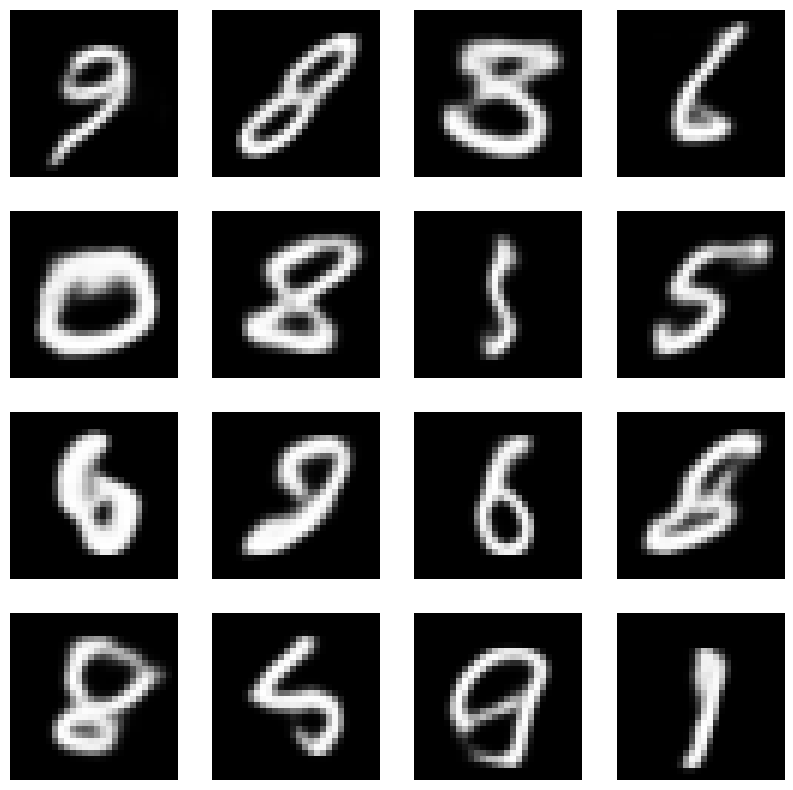

In [207]:
image = generated_images.cpu().numpy()

rows = 4
cols = 4
fig = plt.figure(figsize=(10, 10))
for i in range(1, rows*cols + 1):
    img = image[i-1].squeeze()
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap="gray")
    plt.axis("off")

In [219]:
model.eval()  # set to evaluation mode

# Create a dummy input in the same shape as your real data (1, 1, 28, 28) for a single MNIST image
dummy_input = torch.randn(1, 16, device=device)

# ONNX export
torch.onnx.export(
    model.decoder,                           # the trained model to export
    dummy_input,                     # model input (or a tuple if multiple inputs)
    "vae.onnx",                      # where to save the ONNX file
    export_params=True,              # store the trained parameter weights inside the ONNX file
    opset_version=14,                # ONNX version to export to (commonly 11 or higher)
    do_constant_folding=True,        # whether to do optimizations such as constant folding
    input_names=["input"],           # name for the input layer(s)
    output_names=["image"],  # name the outputs
    dynamic_axes={
        "input": {0: "batch_size"}, 
        "image": {0: "batch_size"},
    }
)


In [220]:
torch.save(model.state_dict(), "vae.pth")

In [221]:
import onnxruntime as ort

In [222]:
session = ort.InferenceSession("vae.onnx", providers=["CPUExecutionProvider"])

In [223]:
dummy_input = np.random.rand(1, 16).astype(np.float32)

In [229]:
out = session.run(None, {"input": dummy_input})